In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
from IPython.display import HTML  # for embedded matplotlib animation
from math import *

matplotlib.rc('animation', html='html5')

Implementation of all the function in module 10.2

Reference: https://ics.wofford-ecs.org/files-to-download


In [ ]:
global AMBIENT, HOT, COLD
AMBIENT = 25.0
HOT = 50.0
COLD = 0.0

In [ ]:
def initBar(m, n, hotSites, coldSites):
#   global AMBIENT
    ambientBar = AMBIENT * np.ones((m, n))
    bar = applyHotCold(ambientBar, hotSites, coldSites)
    return bar

In [ ]:
def applyHotCold(bar, hotSites, coldSites):
    for k in range(len(hotSites)):
        bar[hotSites[k, 0], hotSites[k, 1]] = HOT
    for k in range(len(coldSites)):
        bar[coldSites[k, 0], coldSites[k, 1]] = COLD
    return bar

In [ ]:
def reflectingLat(lat):
    latNS = np.row_stack((lat[0], lat, lat[-1]))
    return np.column_stack((latNS[:,0], latNS, latNS[:,-1]))

In [ ]:
def absorbingLat(lat):
    col = np.full(shape=lat[0].shape,fill_value=ABS_CONST)
    latNS = np.row_stack((col, lat, col))
    row = np.full(shape=latNS[:,0].shape,fill_value=ABS_CONST)

    return np.column_stack((row, latNS, row))

In [ ]:
def periodicLat(lat): #This is the function of the boundary conditions.
    latN = np.row_stack((lat[-1], lat))
    latS = np.row_stack((latN, lat[0]))
    latE = np.column_stack((latS[:,-1], latS))
    return np.column_stack((latE, latS[:,0]))

  # why it is applied ?

In [ ]:
# def diffusion(diffusionRate, site, N, NE, E, SE, S, SW, W, NW):
#     return (1 - 8*diffusionRate)*site + diffusionRate*(N+NE+E+SE+S+SW+W+NW)

In [ ]:
def weighted_diff(diffusionRate, site, N, NE, E, SE, S, SW, W, NW):
  # sites = np.empty(8)
  # sites.fill(site)

  neighbour = np.array([N, NE, E, SE, S, SW, W, NW])
  weights = diffusionRate[1:]

  # return site + np.dot(weights, (neighbour - sites))
  return ((1 - (8 * diffusionRate[0])) * site) + np.dot(weights, neighbour)

In [ ]:
def applyDiffusionExtended(diffusionRate, latExt):
    m = latExt.shape[0] - 2
    n = latExt.shape[1] - 2
    newLat = np.zeros((m, n))

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            site = latExt[i, j]
            N = latExt[i - 1, j]
            NE = latExt[i - 1, j + 1]
            E = latExt[i, j + 1]
            SE = latExt[i + 1, j + 1]
            S = latExt[i + 1, j]
            SW = latExt[i + 1, j - 1]
            W = latExt[i, j - 1]
            NW = latExt[i - 1, j - 1]
            newLat[i - 1, j - 1] = weighted_diff(diffusionRate, site, N, NE, E, SE, S, SW, W, NW);
    return newLat

In [ ]:
def  diffusionSim(m, n, diffusionRate, hotSites, coldSites, t, boundary):
    # Initialize grid
    bar = initBar(m, n, hotSites, coldSites)

    # Perform simulation
    grids = np.zeros((t + 1, m, n))
    grids[0, :, :] = bar
    for i in range(1, t + 1):
        # Extend matrix
        barExtended = boundary(bar)
        # Apply spread of heat function to each grid point
        bar = applyDiffusionExtended(diffusionRate, barExtended)
        # reapply hot and cold spots
        bar = applyHotCold(bar, hotSites, coldSites)
        # Save new matrix
        grids[i, :, :] = bar
    return grids

In [ ]:
 def animate_simulation(grids, time):
  Writer = animation.writers['ffmpeg']
  writer = Writer(fps=60, metadata=dict(artist='Me'), bitrate=1800)

  figGray = plt.figure()
  plt.axis('off')
  imGray = plt.imshow(grids[0,:,:], cmap='gray', interpolation='nearest', animated=True)

  # The animation function, called to produce a frame for each generation.
  def updatefig(i, *args):
      global grids
      imGray.set_array(grids[i,:,:])
      return imGray,

  grid_ani = animation.FuncAnimation(figGray, updatefig, save_count = len(grids),
                                    interval=50, blit=False)
  plt.show()

  # To save the animation, use the command, placed before HTML:
  grid_ani.save('DiffusionGray.mp4', writer=writer)

  return HTML(grid_ani.to_html5_video())

In [ ]:
m = 10
n = 30
# diffusionRate is rate_of_diffusion in all * direction N, NE, E, SE, S, SW, W, NW
diffusionRate = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
# diffusionRate = 0.1

hotSites = np.array([[floor(m/2),0],[floor(m/2)+1,0],[floor(m/2)+2,0],
                    [0,floor(m/2)]])
coldSites = np.array([[m-1,floor(n/3)-2],[m-1,floor(n/3)-1],
                        [m-1,floor(n/3)],[m-1,floor(n/3)+1],
                         [m-1,floor(n/3)+2]])
t = 50

White cells are hotSites and Black cells are coldSites

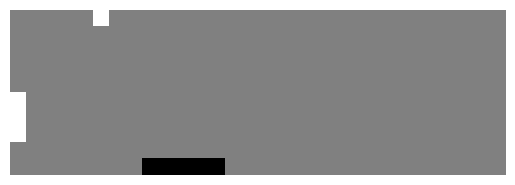

In [ ]:
# Simple simulation of Heat Diffusion using above parameters
grids = diffusionSim(m, n, diffusionRate, hotSites, coldSites, t, reflectingLat)
animate_simulation(grids, t)



1.

a. Determine how long it takes, t, for the bar modeled in this module to reach
equilibrium, where from time t to time t + 1 the values in each cell vary by
no more than plus or minus some small value, such as ±0.001.

In [ ]:
def diffusionEqui(m, n, diffusionRate, hotSites, coldSites, boundary):
    # Initialize grid
    bar = initBar(m, n, hotSites, coldSites)

    # Perform simulation
    grids = np.zeros((2, m, n))
    grids[1, :, :] = bar
    grids[0, :, :] = np.zeros((m, n))
    i = 1

    while not np.allclose(grids[i, :, :], grids[i-1, :, :], 1e-3):
        # Extend matrix
        barExtended = boundary(bar)
        # Apply spread of heat function to each grid point
        bar = applyDiffusionExtended(diffusionRate, barExtended)
        # reapply hot and cold spots
        bar = applyHotCold(bar, hotSites, coldSites)
        # Save new matrix
        grids = np.vstack((grids, [bar]))
        # print(i)
        i+=1
    return grids[1:,:,:], i

133


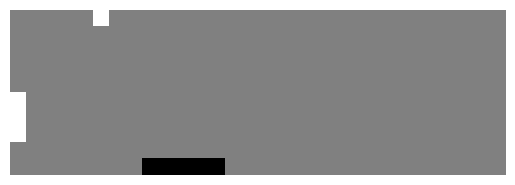

In [ ]:
grids, time = diffusionEqui(m, n, diffusionRate, hotSites, coldSites, reflectingLat)
print(time)
animate_simulation(grids, time)
# print(grids[time - 1,:,:])

b. Repeat Part a, applying heat and cold for 10 time steps and then removing
such heating and cooling.

In [ ]:
def diffusionEqui_stops(m, n, diffusionRate, hotSites, coldSites, t, boundary):
    # Initialize grid
    bar = initBar(m, n, hotSites, coldSites)

    # Perform simulation
    grids = np.zeros((2, m, n))
    grids[1, :, :] = bar
    grids[0, :, :] = np.zeros((m, n))
    i = 1

    while not np.allclose(grids[i, :, :], grids[i-1, :, :], 1e-3):
        # Extend matrix
        barExtended = boundary(bar)
        # Apply spread of heat function to each grid point
        bar = applyDiffusionExtended(diffusionRate, barExtended)
        # reapply hot and cold spots
        if (i <= t):
          bar = applyHotCold(bar, hotSites, coldSites)
        # Save new matrix
        grids = np.vstack((grids, [bar]))
        # print(i)
        i+=1
    return grids[1:,:,:], i

110


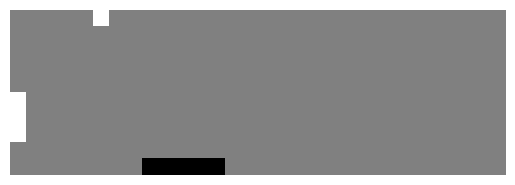

In [ ]:
stop_after = 10
grids, time = diffusionEqui_stops(m, n, diffusionRate, hotSites, coldSites, stop_after, reflectingLat)
print(time)
animate_simulation(grids, time)

In [ ]:
print(grids[-1,:,:])

[[27.65259425 27.57055439 27.41118186 27.18352262 26.90025938 26.57674237
  26.22984345 25.87673877 25.53372909 25.21519903 24.93279862 24.69490445
  24.50638659 24.36867553 24.28009384 24.23639392 24.23142836 24.25787424
  24.30793689 24.37397067 24.44897227 24.52692187 24.60296773 24.67346649
  24.73590458 24.78873322 24.83115237 24.86287734 24.88391755 24.89439091]
 [27.63316725 27.55056593 27.39012214 27.16098009 26.87595784 26.55056529
  26.20184337 25.84713167 25.50287483 25.18357051 24.90094323 24.66340189
  24.47580719 24.33954279 24.252854   24.21139455 24.20890674 24.23795518
  24.29063893 24.35921884 24.43661518 24.51675099 24.59473671 24.66690882
  24.7307483  24.78471185 24.82801183 24.86037894 24.88183746 24.89251684]
 [27.59620575 27.51253645 27.35005493 27.11809229 26.82972411 26.50076392
  26.14857435 25.79080585 25.44417676 25.12339976 24.84034108 24.60347109
  24.41763271 24.28412046 24.20103272 24.16383555 24.16606138 24.20006091
  24.25773103 24.33115468 24.4131067

[  0.           5.05050505  10.1010101   15.15151515  20.2020202
  25.25252525  30.3030303   35.35353535  40.4040404   45.45454545
  50.50505051  55.55555556  60.60606061  65.65656566  70.70707071
  75.75757576  80.80808081  85.85858586  90.90909091  95.95959596
 101.01010101 106.06060606 111.11111111 116.16161616 121.21212121
 126.26262626 131.31313131 136.36363636 141.41414141 146.46464646
 151.51515152 156.56565657 161.61616162 166.66666667 171.71717172
 176.76767677 181.81818182 186.86868687 191.91919192 196.96969697
 202.02020202 207.07070707 212.12121212 217.17171717 222.22222222
 227.27272727 232.32323232 237.37373737 242.42424242 247.47474747
 252.52525253 257.57575758 262.62626263 267.67676768 272.72727273
 277.77777778 282.82828283 287.87878788 292.92929293 297.97979798
 303.03030303 308.08080808 313.13131313 318.18181818 323.23232323
 328.28282828 333.33333333 338.38383838 343.43434343 348.48484848
 353.53535354 358.58585859 363.63636364 368.68686869 373.73737374
 378.787878

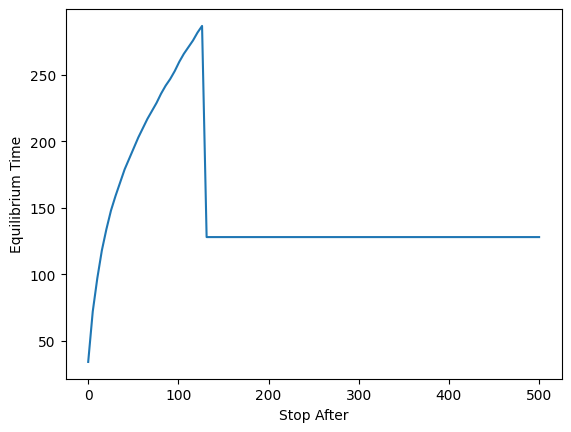

In [ ]:
stop_after = np.linspace(0, 500, 100)
equ_time = []
for i in stop_after:
    grids, time = diffusionEqui_stops(m, n, diffusionRate, hotSites, coldSites, i, periodicLat)
    equ_time = np.append(equ_time, time)
print(stop_after)
print(equ_time)
plt.plot(stop_after, equ_time)
plt.xlabel('Stop After')
plt.ylabel('Equilibrium Time')
plt.show()

2. Develop simulations and animations for the bar modeled in this module using several boundary conditions: three simulations of absorbing boundary conditions with constant values 0, 25, and 50 and periodic boundary conditions.

Along with the reflecting boundary conditions, describe the results. Discuss
the advantages and disadvantages of each approach and the situations, such
as heat or pollution diffusion, for which each is most appropriate.

In [ ]:
global ABS_CONST
ABS_CONST = 0
t = 200

343


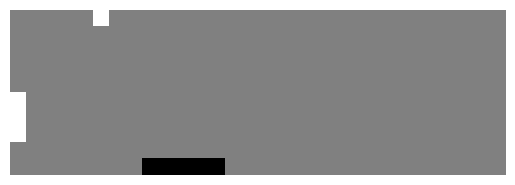

In [ ]:
grids, time = diffusionEqui(m, n, diffusionRate, hotSites, coldSites, absorbingLat)
print(time)
animate_simulation(grids,  time)

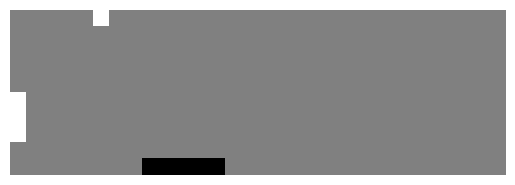

In [ ]:
# grids = diffusionSim(m, n, diffusionRate, coldSites, hotSites, t, periodicLat)
grids = diffusionSim(m, n, diffusionRate, hotSites, coldSites, t, periodicLat)

animate_simulation(grids, t)

3. Instead of using the formula for diffusion in the section “Heat Diffusion,”
employ the filter in Figure 10.2.13. Thus, to obtain the value at a site for time
t + 1, we add 25% of the site’s temperature at time t, 12.5% of the north, east,
south, and west cells at time t, and 6.25% of the corner cells to the northeast,
southeast, southwest, and northwest. This sum is called a weighted sum with
each nutrition value carrying a particular weight as indicated by the table.
Revise the model using this configuration and compare the results with that
of the module.

135


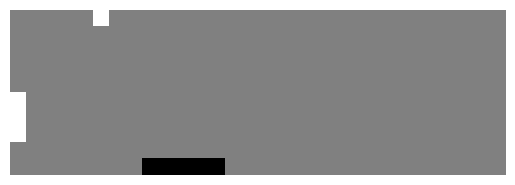

In [ ]:
diffusionRate = np.array([(1- 0.25)/8, 0.125, 0.0625, 0.125, 0.0625, 0.125, 0.0625, 0.125, 0.0625])
# diffusionRate = np.array([(1- 0.25)/8, 0.0, 0.0625, 0.0, 0.0625, 0.0, 0.0625, 0.0, 0.0625])
# diffusionRate = np.array([(1- 0.25)/8, 0/.125, 0, 0.125, 0.0, 0.125, 0.0, 0.125, 0.0])
# grids = diffusionSim(m, n, diffusionRate, hotSites, coldSites, t, reflectingLat)
# animate_simulation(grids, t)

grids, time = diffusionEqui(m, n, diffusionRate, hotSites, coldSites, reflectingLat)
print(time)
# print(grids[0, :, :])
animate_simulation(grids, time)